In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *
from training_func import *

In [2]:
torch.cuda.is_available()

False

In [3]:
# G_21 = xr.open_dataset("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/G_21_subset_imputed.nc")
# G_21 = G_21.to_array().values.squeeze(0)
# G_21.shape

In [4]:
from pandas_plink import read_plink1_bin, Chunk
ABCD_full = read_plink1_bin("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/ABCD_20220428.updated.nodups.curated.bed",
                      chunk=Chunk(nsamples=100, nvariants=None))
freq_snp = ABCD_full.mean(axis = 0)/2
sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
# a subset that have variability in the SNPs
ABCD_sub = ABCD_full[:,~sd_snp.isin(0)]
freq_snp = ABCD_sub.mean(axis = 0)/2
sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
ABCD_sub = (ABCD_sub-2*freq_snp)/sd_snp
ABCD_sub.persist()


Mapping files: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


<xarray.DataArray 'genotype' (sample: 11389, variant: 509151)>
dask.array<truediv, shape=(11389, 509151), dtype=float32, chunksize=(100, 509151), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * sample   (sample) object 'NDAR_INV003RTV85' ... 'NDAR_INVZZZP87KR'
  * variant  (variant) <U13 'variant0' 'variant1' ... 'variant516597'
    fid      (sample) object 'NDAR_INV003RTV85' ... 'NDAR_INVZZZP87KR'
    iid      (sample) object 'NDAR_INV003RTV85' ... 'NDAR_INVZZZP87KR'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    ...       ...
    chrom    (variant) object '1' '1' '1' '1' '1' ... '26' '26' '26' '26' '26'
    snp      (variant) object 'rs3131972' 'rs3131962' ... 'chr26:16526'
    cm       (variant) float64 0.008 0.008 0.009 0.009 0.009 ... 0.0 0.0 0.0 0.0
    pos      (variant) int32 752721 756604 779322 795222 ... 16356 16362 16526
    a0       (variant) object 'A' 'A' 'G' 'G' 'G' 'G' ... 'T' 'C' 'C' 'C' 'A'
    a1       (variant) object 'G' 'G' 'A' 'C' 'A' 'A' ... 'C' 'T' 'T' 'T' 'G'

In [85]:
ABCD_sub =  ABCD_sub.values
ABCD_sub[np.isnan(ABCD_sub)]=0

NameError: name 'ABCD_sub' is not defined

In [6]:
ABCD_sub.shape

(11389, 509151)

In [258]:
real_data_index = False
max_n_p = True
n = 200
p = 1001
p_causal = 20
batch_size = 200
r_batch = batch_size/n
device = 'cpu'
if real_data_index:
    if not max_n_p:
        np.random.seed(seed = None)
        p_max = ABCD_sub.shape[1]
        n_max = ABCD_sub.shape[0]
        SNP_index = np.random.choice(p_max,size = p, replace = False)
        subject_index =  np.random.choice(n_max,size = n, replace = False)
        ABCD_sub_sub = ABCD_sub[np.ix_(subject_index, SNP_index)]
        print(ABCD_sub_sub.shape)
        Xs = [ABCD_sub_sub]
    else:
        Xs = [ABCD_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None
print(r_batch)

1.0


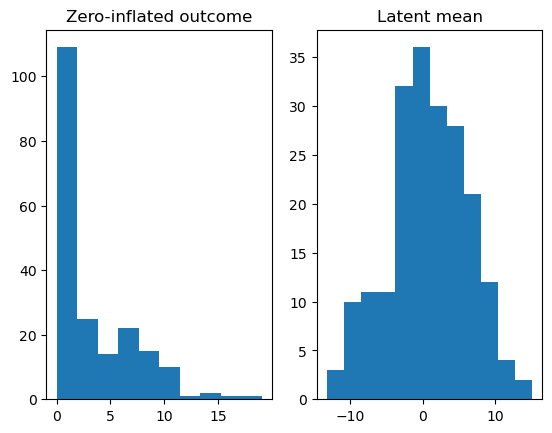

------------------------------------
genetic variance is 28.697443112761682
total variance is35.8718038909521
heritability is 0.8
------------------------------------


In [259]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.8
beta_bias = 1
exact_lh = False
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal, rho = rho, var = var, n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)

In [260]:
sim_data = Sim_Dataset(X,y_star, device = device)
sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
model = linear_slab_spike(p = p, n_total = n, init_pi_local = 0.5, init_pi_global = 0.1, init_beta_var =1, init_noise_var = 0.1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                          a1= 0.1, a2=1, init_a3= 0.1, init_a4 = 0.1,
                          b1 = 1.1, b2 = 1.1, init_b3 = 1.1, init_b4 = 1.1, n_E = 1
                          , prior_sparsity = True, prior_sparsity_beta = True,exact_lh = exact_lh, device = device
                         ).double().to(device)
optimizer = torch.optim.Adam(
    [{'params': model.beta_mu},
     {'params': model.beta_log_var},
     {'params': model.logit_pi_local, 'lr': 0.5},
     {'params': model.log_a3},
     {'params': model.log_a4},
     {'params': model.log_b3},
     {'params': model.log_b4},
     {'params': model.bias},
     {'params': model.logit_pi_global, 'lr':0.5},
     {'params': model.beta_log_var_prior},
     {'params': model.log_var_noise},
    ],
    lr = 0.05)

At iteration 0, the loss is 25150.32427756755
At iteration 1000, the loss is 963.6700496919511
At iteration 2000, the loss is 909.672114264056


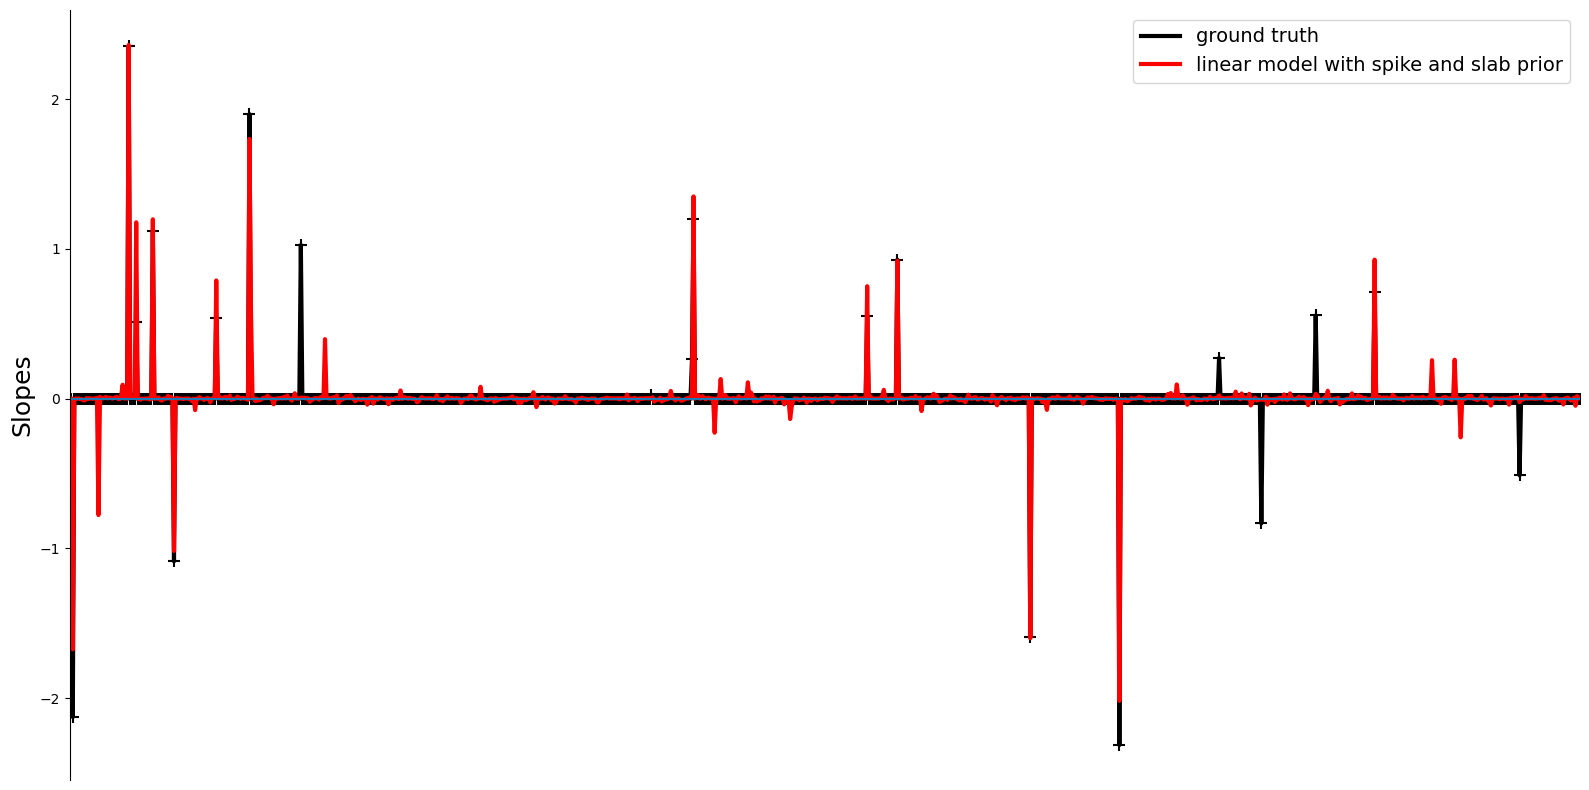

In [261]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
t = 100 #number of moving averages
patience = 100# patience
_, result_dict = train_and_infer(model = model, optimizer = optimizer, sim_data_loader = sim_data_loader, lr_scheduler = lr_scheduler, t = t, patience = patience,X = X, plot = True, true_beta = true_beta, verbose = True)

In [262]:
result_dict

{'mean_h_est': [0.7928146628838006],
 'h_est_upper': [0.9161927950281488],
 'h_est_lower': [0.5670226906830299],
 'mean_var_genetic': [34.71215697739699],
 'noise_var': [9.634790217494189],
 'global_pi': [0.029262021561476278],
 'global_pi_upper': [0.06243787397643955],
 'global_pi_lower': [0.009492576621000505]}

In [263]:
p_causal/p

0.01998001998001998

In [264]:
pi_VI = torch.sigmoid(model.logit_pi_local).detach().numpy()

In [265]:
# torch.sum(torch.sigmoid(model.logit_pi_local)>0.9)/p
print(torch.max(torch.sigmoid(model.logit_pi_local)))
print(torch.min(torch.sigmoid(model.logit_pi_local)))
# torch.min(model.beta_mu)
# torch.max(model.beta_mu)
torch.exp(model.beta_log_var)
print(torch.mean(torch.exp(model.beta_log_var)))

tensor(1.0000, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5507e-08, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.7469, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [266]:
# c = torch.exp(best_model.log_c).detach().numpy()
# d = torch.exp(best_model.log_d).detach().numpy()
# # c = 10
# # d = 10
# print(c)
# print(d)
# posterior = np.random.beta(c,d,size = (5000,))
# np.median(posterior)
# print(np.quantile(posterior, q = 0.025))
# print(np.quantile(posterior, q = 0.975))
# plt.hist(posterior)
# plt.show()

# MCMC algorithm

In [267]:
from mcmc_linear import experiment, linear_mcmc_model
import jax.numpy as jnp

def comparison_plot(est, true):
    p = len(true)
    fig = plt.figure(figsize=(16,8), facecolor='white')
    ax = fig.add_subplot(1,1,1)
    ax.plot(np.arange(p), true, \
           linewidth = 3, color = "black", label = "ground truth")
    ax.scatter(np.arange(p), true, \
           s = 70, marker = '+', color = "black")
    ax.plot(np.arange(p),  est, \
               linewidth = 3, color = "red", \
               label = "linear model with spike and slab prior")
    ax.set_xlim([0,p-1])
    ax.set_ylabel("Slopes", fontsize=18)
    ax.hlines(0,0,p-1)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.legend(prop={'size':14})
    fig.set_tight_layout(True)
    plt.show()




In [268]:
exp = experiment(linear_mcmc_model, y_star.numpy(), X.numpy())
exp.train(step_size =1,verbose = True)
heritability, genetic_var, data_var = exp.cal_heritability()

sample: 100%|█| 1200/1200 [00:29<00:00, 41.20it/s, 63 steps of size 1.49e-01. ac


In [269]:
posterior = exp.mcmc.get_samples()
beta = posterior["beta"]* posterior["delta"]
g_var = (beta @ jnp.transpose(X.numpy()) ).var(axis = 1)
dat_var = posterior["var_error"]
heritability = g_var/(dat_var+g_var)
print('point estimate of heritability: '+ str(np.mean(heritability)))
print('lower bound of heritability: '+ str(np.quantile(heritability, 0.025)))
print('upper bound of heritability: '+ str(np.quantile(heritability, 0.975)))
print('point estimate of p_causal: '+ str(np.mean(exp.mcmc.get_samples()['pi'], axis = 0)))
print('lower bound of p_causal: '+ str(np.quantile(exp.mcmc.get_samples()['pi'], 0.025)))
print('upper bound of p_causal: '+ str(np.quantile(exp.mcmc.get_samples()['pi'], 0.975)))

point estimate of heritability: 0.82759964
lower bound of heritability: 0.7757428914308548
upper bound of heritability: 0.87895088493824
point estimate of p_causal: 0.02604836
lower bound of p_causal: 0.01407195117790252
upper bound of p_causal: 0.04296755800023675


0.11295411
0.001
1.0
0.008


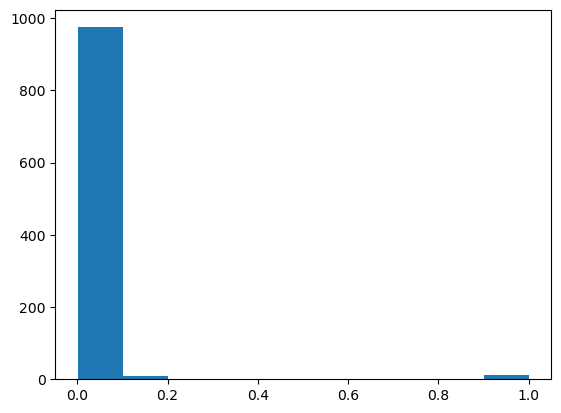

In [270]:
pi_mcmc = np.mean(posterior["delta"], axis = 0)
plt.hist(pi_mcmc)
print(np.std(pi_mcmc))
print(np.min(pi_mcmc))
print(np.max(pi_mcmc))
print(np.median(pi_mcmc))

0.10869862382086676
1.5506858770940714e-08
0.9999734475626172
0.014846090905855992


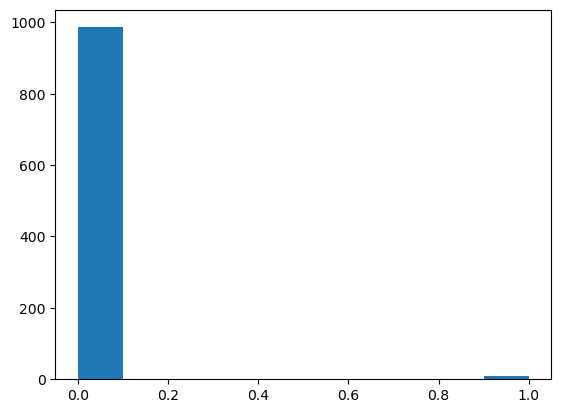

In [271]:
plt.hist(pi_VI)
print(np.std(pi_VI))
print(np.min(pi_VI))
print(np.max(pi_VI))
print(np.median(pi_VI))

In [272]:
print(np.where(pi_VI>0.3))
print(pi_VI[np.where(pi_mcmc>0.3)])

(array([  2,  19,  39,  44,  55,  69,  97, 119, 120, 413, 528, 548, 636,
       695, 864]),)
[9.96510046e-01 9.99973448e-01 9.99654691e-01 9.99741373e-01
 9.99494213e-01 8.59760957e-01 9.99816490e-01 2.06761670e-02
 9.34829834e-01 6.54521506e-01 9.61717108e-01 9.99099952e-01
 9.84804322e-01 3.35998120e-04 8.89538506e-01]


In [273]:
pi_mcmc[np.where(pi_mcmc>0.3)]

Array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.90700006, 1.        , 0.87700003, 1.        , 0.49      ,
       0.989     , 1.        , 1.        , 0.61600006, 0.855     ],      dtype=float32)

In [274]:
beta_VI = model.beta_mu.detach().numpy()
beta_mcmc = np.mean(posterior["beta"], axis = 0)

In [275]:
print(beta_VI[np.where(beta_mcmc>0.5)])
print(beta_mcmc[np.where(beta_mcmc>0.5)])
print(pi_VI[np.where(beta_mcmc>0.5)])
print(pi_mcmc[np.where(beta_mcmc>0.5)])

[2.26982946 1.10632478 1.35544331 0.70606908 1.81727693 0.0277653
 1.23225654 0.96772907 1.03293517]
[2.2174973  0.97845536 1.3145336  0.66171294 1.9166709  0.699354
 1.3331995  0.97188276 0.7719359 ]
[0.99997345 0.99965469 0.99974137 0.85976096 0.99981649 0.02067617
 0.93482983 0.96171711 0.88953851]
[1.         1.         1.         0.90700006 1.         0.87700003
 1.         0.989      0.855     ]


In [276]:
print(beta_VI[np.where(beta_VI>0.5)])
print(beta_mcmc[np.where(beta_VI>0.5)])

[2.26982946 1.10632478 1.35544331 0.70606908 1.81727693 0.7704489
 1.23225654 0.79742927 0.96772907 1.03293517]
[2.2174973  0.97845536 1.3145336  0.66171294 1.9166709  0.1229447
 1.3331995  0.3709126  0.97188276 0.7719359 ]


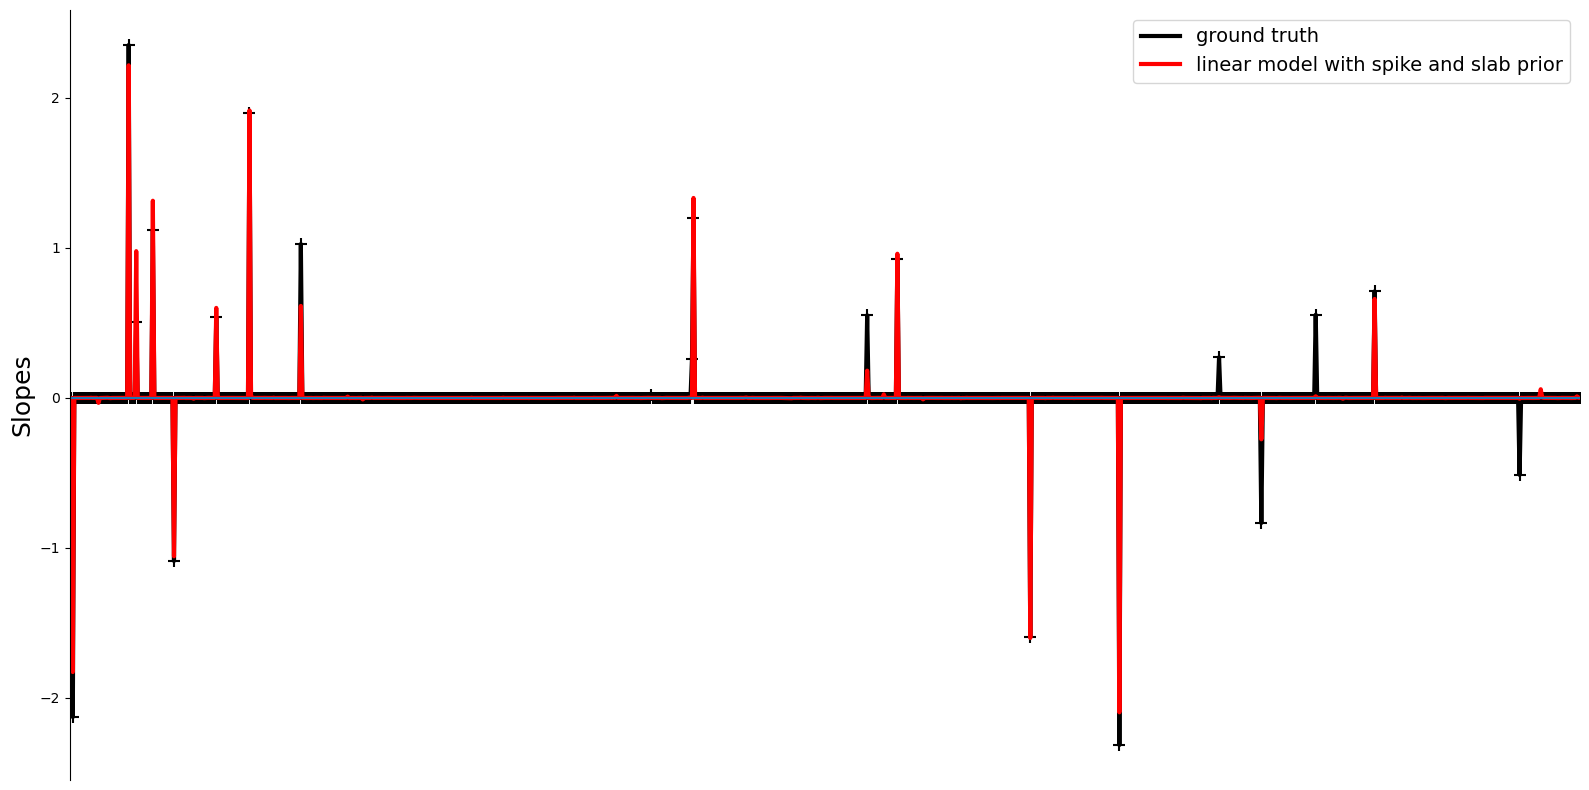

In [277]:
comparison_plot(beta_mcmc*pi_mcmc, true_beta)

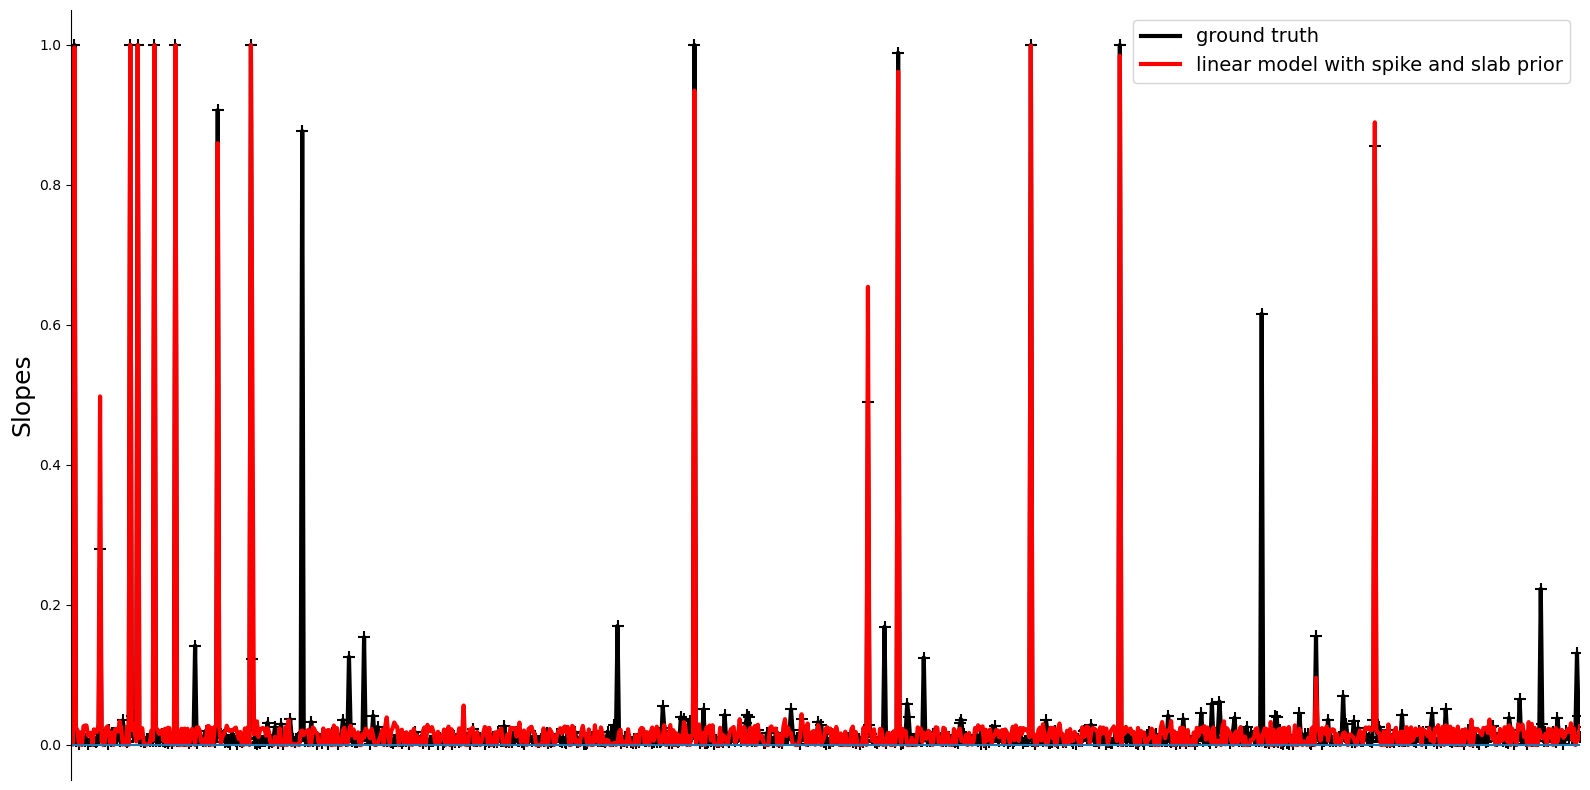

In [278]:
comparison_plot(pi_VI, pi_mcmc)

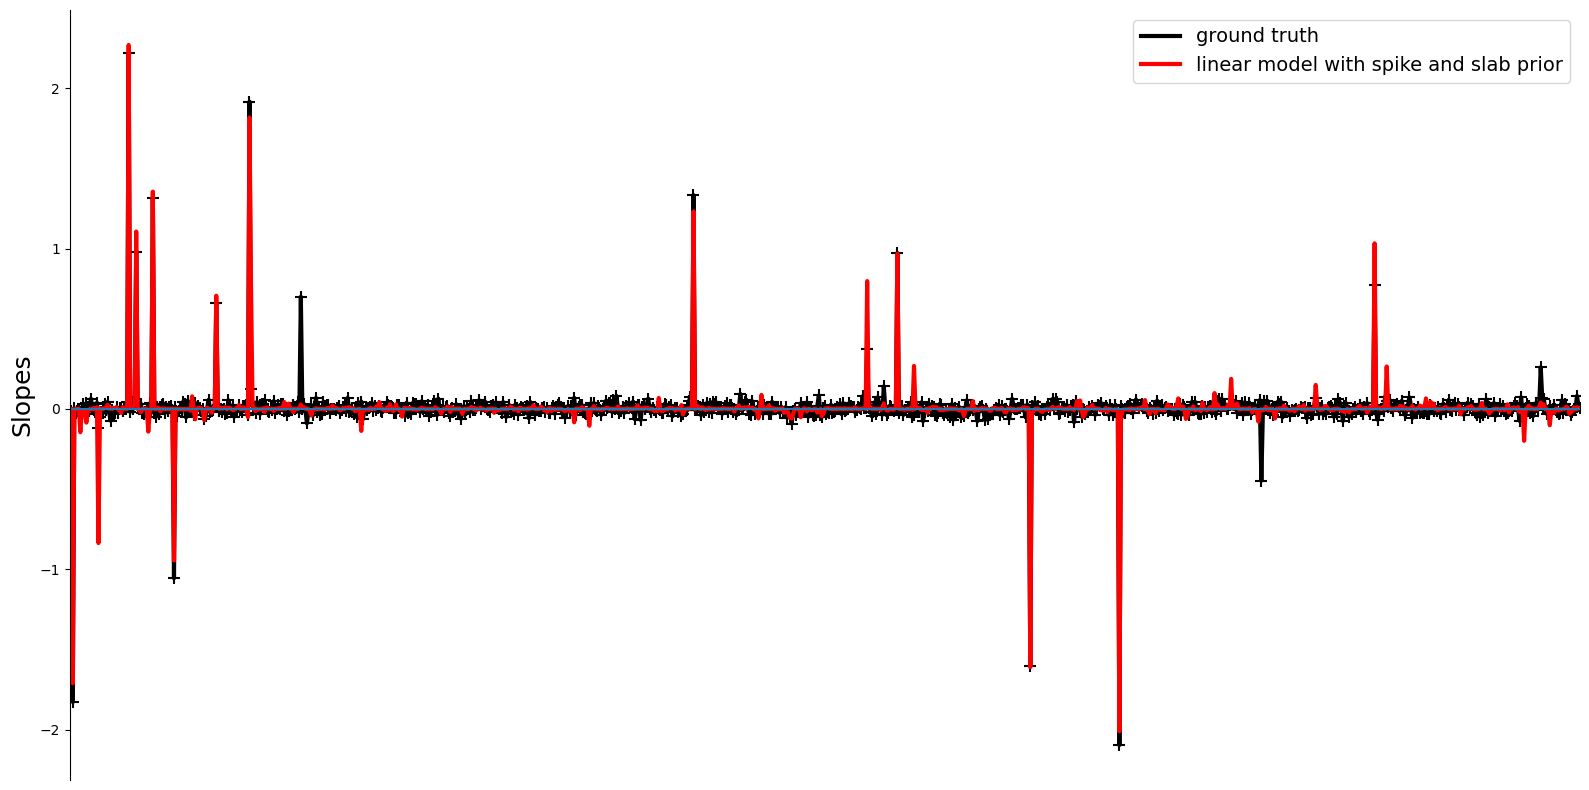

In [279]:
comparison_plot(beta_VI, beta_mcmc)